In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cmcrameri

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
cmap_name = "cmc.roma_r"
cmap = plt.get_cmap(cmap_name)
plt.rcParams['image.cmap'] = cmap_name

# Load data

In [3]:
path = "../../data/application/"


In [4]:
file = xr.open_dataset(path + "1931_2020_raw.nc")

In [5]:
## Coordinates
lats = [45.08990097,55.71120071]
lons = [1.83469999, 21.39039993]

lon_range = np.linspace(lons[0], lons[1], 1200)
lat_range = np.linspace(lats[0], lats[1], 1100)

In [251]:
file

<xarray.Dataset>
Dimensions:             (time: 32934, bnds: 2, y: 1100, x: 1200)
Coordinates:
  * time                (time) datetime64[ns] 1930-11-01T18:00:00 ... 2020-12...
    lon                 (y, x) float64 3.427 3.441 3.454 ... 21.36 21.37 21.39
    lat                 (y, x) float64 45.29 45.29 45.29 ... 55.21 55.21 55.21
  * x                   (x) float32 3.5e+06 3.502e+06 ... 4.698e+06 4.7e+06
  * y                   (y) float32 2.1e+06 2.102e+06 ... 3.198e+06 3.2e+06
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] ...
    x_bnds              (x, bnds) float32 3.5e+06 3.501e+06 ... 4.7e+06
    y_bnds              (y, bnds) float32 ...
    crs_HYRAS           int32 ...
    pr                  (time, y, x) float32 ...
    number_of_stations  (time) float64 ...
Attributes: (12/20)
    source:                    surface observations
    Conventions:               CF-1.8
    references:                https://opendata.dwd.de/climate_environment/CD...
    realization:               v5.0
    version_hyras_background:  v3.0
    project_id:                HYRAS
    ...                        ...
    title:                     gridded_precipitation_dataset_(HYRAS-DE PRE)
    input_data_status:         non-realtime
    institution:               Deutscher Wetterdienst (DWD)
    creation_date:             created at 2022-12-06 00:47:44
    unique_dataset_id:         DWD_HYRAS_DE_1km_pr_v5.0_1931_2020_day_00638E9130
    filename:                  pr_hyras_1_1931_2020_v5-0_de.nc

In [6]:
file = xr.open_dataset(path + "2021_raw.nc")
data = file.pr.sel(time = "2021-07").max(dim = "time", skipna = True)

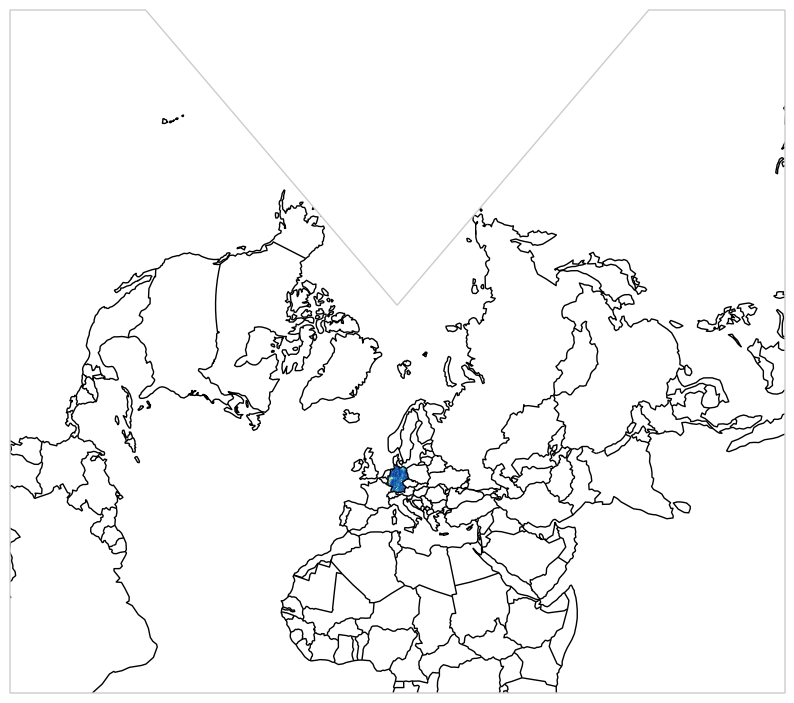

In [76]:

fig, axs = plt.subplots(subplot_kw={'projection': ccrs.LambertConformal(central_longitude=10, central_latitude=52,
                                                                        standard_parallels=(35,65), false_easting=4000000,
                                                                        false_northing=2800000)},figsize=(10,18))
axs.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
axs.coastlines()
axs.add_feature(cfeature.BORDERS)
ger_shape = list(shpreader.Reader(path+"ger_shape/gadm41_DEU_1.shp").geometries())
axs.add_geometries(ger_shape, ccrs.PlateCarree(),
                 edgecolor='black', facecolor = "None", lw = 0.3)

pcm = axs.pcolormesh(data.x, data.y, data)


In [220]:
# Define area
from pyresample.geometry import AreaDefinition
from pyresample.geometry import SwathDefinition
from pyresample.bilinear import XArrayBilinearResampler
from pyresample import kd_tree,geo_filter
area_id = 'original'
description = 'Original grid'
proj_id = 'id'

projection = "+proj=lcc +lat_1=35 +lat_2=65 +lat_0=52 +lon_0=10 +x_0=4000000 +y_0=2800000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
width = 1200
height = 1100

area_extent = (3500000, 2100000, 4700000, 3200000)

area_def = AreaDefinition(area_id, description, proj_id, projection,width, height, area_extent)
lons, lats = area_def.get_lonlats()
area_def

Area ID: original
Description: Original grid
Projection ID: id
Projection: {'ellps': 'GRS80', 'lat_0': '52', 'lat_1': '35', 'lat_2': '65', 'lon_0': '10', 'no_defs': 'None', 'proj': 'lcc', 'towgs84': '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]', 'type': 'crs', 'units': 'm', 'x_0': '4000000', 'y_0': '2800000'}
Number of columns: 1200
Number of rows: 1100
Area extent: (3500000, 2100000, 4700000, 3200000)

In [221]:
area_target = AreaDefinition(area_id, description, proj_id, "+proj=eqc",width, height, area_extent) 

In [227]:
lons = np.linspace(6.45,7.15,30)
lats = np.linspace(50.25,50.95,30)

# The target grid is regular (1-d lon, lat coordinates) but we will need
# a 2d version (similar to the input grid), so use numpy.meshgrid to produce this.
lon2d, lat2d = np.meshgrid(lons, lats)

In [228]:
target_grid = SwathDefinition(lons = lon2d, lats = lat2d)

In [229]:
result = kd_tree.resample_nearest(area_def, data.data, target_grid, radius_of_influence=50000, epsilon=0.5)

(47.2, 55.2)

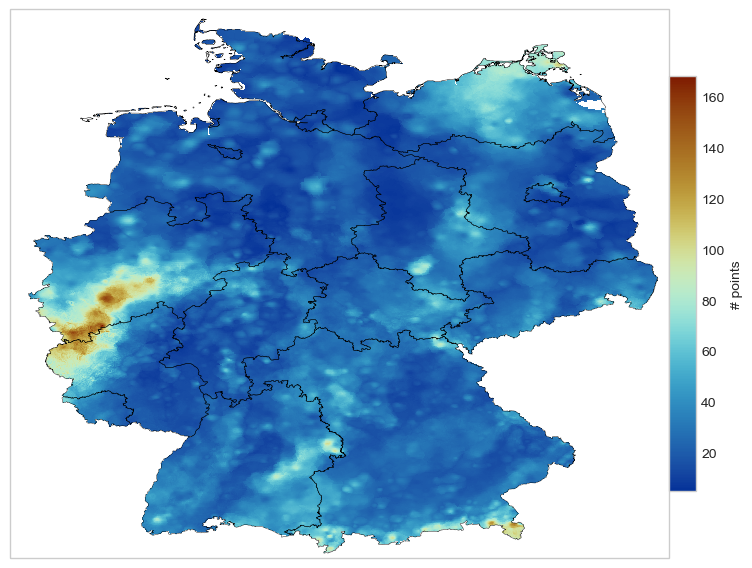

In [230]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(10,18))

axs.set_extent([lons[0],lons[1],lats[0],lats[1]])


ger_shape = list(shpreader.Reader(path+"ger_shape/gadm41_DEU_1.shp").geometries())
axs.add_geometries(ger_shape, ccrs.PlateCarree(),
                  edgecolor='black', facecolor = "None", lw = 0.3)
#axs.add_feature(cfeature.BORDERS)
#axs.coastlines(resolution='10m')

pcm = axs.pcolormesh(data.lon, data.lat, data, transform = ccrs.PlateCarree())
fig.colorbar(pcm, ax=axs, label="# points", pad=0, shrink = 0.3, aspect = 15)

axs.set_xlim([5.6,15.2])
axs.set_ylim([47.2,55.2])

Text(6.8031625, 50.8027168, 'Erftstadt')

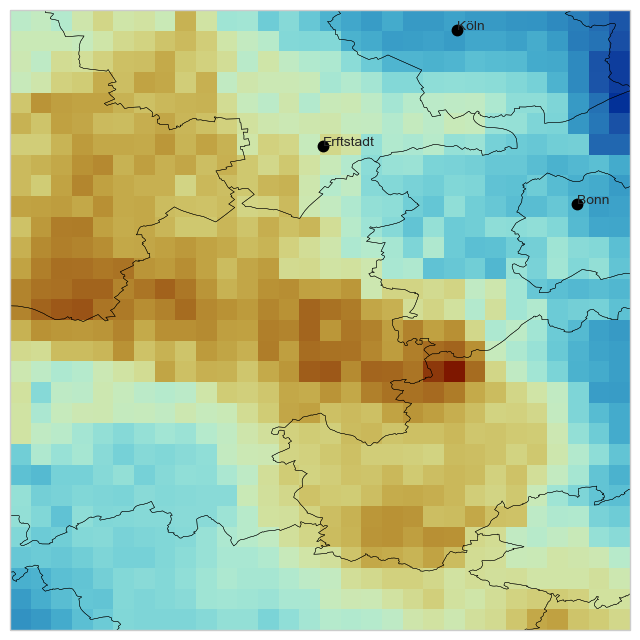

In [231]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(8,15))

ger_shape = list(shpreader.Reader(path+"ger_shape/gadm41_DEU_2.shp").geometries())
axs.add_geometries(ger_shape, ccrs.PlateCarree(),
                  edgecolor='black', facecolor = "None", lw = 0.3)

axs.pcolormesh(lons, lats, result)

axs.plot(7.10066, 50.735851, ".", color = "black", markersize=15)
axs.text(7.10066, 50.735851, 'Bonn')

axs.plot(6.959974, 50.938361, ".", color = "black", markersize=15)
axs.text(6.959974, 50.938361, 'Köln')

axs.plot(6.8031625, 50.8027168, ".", color = "black", markersize=15)
axs.text(6.8031625, 50.8027168, 'Erftstadt')

#axs.set_xlim([5.6,15.2])
#axs.set_ylim([47.2,55.2])